In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
IMG_PATH = "boat_2.jpg"
IMG_SIZE = (224, 224)
LAST_CONV_LAYER = "block5_conv3"
CLASSIFIER_LAYER_NAMES = [
    "block5_pool",
    "flatten",
    "fc1",
    "fc2",
    "predictions",
]

In [3]:
# model_builder = keras.applications.vgg16.VGG16
# preprocess_input = keras.applications.vgg16.preprocess_input
# decode_predictions = keras.applications.vgg16.decode_predictions

In [5]:
IMG_SIZE = (299, 299)
LAST_CONV_LAYER = "block14_sepconv2_act"
CLASSIFIER_LAYER_NAMES = [
    "avg_pool",
    "predictions",
]
model_builder = keras.applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

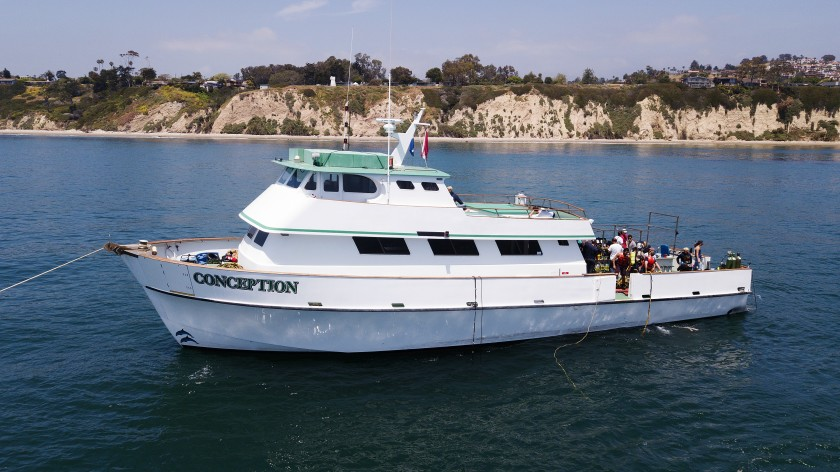

In [6]:
last_conv_layer_name = LAST_CONV_LAYER
classifier_layer_names = CLASSIFIER_LAYER_NAMES
image_size = IMG_SIZE
# img_path = keras.utils.get_file("cat_dog.png", "./cat_dog.png")
display(Image(IMG_PATH))

In [7]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, 
    last_conv_layer_name, 
    classifier_layer_names
):
    # Create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    # Create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]
        
    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # This is the vector where each entry is the mean intensity of the 
    # gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # We multiply each channel in the feature map array
    # by "how importat this channels is" with regards to 
    # the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    
    # For visualization, normalize the heatmap between [0, 1]
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    return heatmap

def superimpose_heatmap(image_path, heatmap):
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap_orig)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((img.shape[1], img.shape[0]))
    
    heatmap = keras.preprocessing.image.img_to_array(heatmap)
    superimposed_img = cv2.addWeighted(heatmap, 0.4, img, 0.6, 0)
    
    return superimposed_img

## Prepare Image

In [ ]:
img_array = get_img_array(IMG_PATH, size=image_size)
print(img_array.shape)
img_array = preprocess_input(img_array)
model = model_builder(weights="imagenet")
preds = model.predict(img_array)
print(f"Predicted: {decode_predictions(preds, top=1)[0]}")

(1, 299, 299, 3)


In [ ]:
model.summary()

In [ ]:
heatmap_orig = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

print(heatmap_orig.shape)

In [ ]:
superimposed_image = superimpose_heatmap(IMG_PATH, heatmap_orig)

In [ ]:
save_path = "superimposed_image.jpg"

In [ ]:
cv2.imwrite(save_path, superimposed_image)
display(Image(save_path))

In [ ]:
!wget https://i.guim.co.uk/img/media/56e07b1e3aaf6bcb7fe25d17d0e026238911c2bc/0_0_3744_2246/master/3744.jpg